In [1]:
import numpy as np
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [2]:
#Read the csv file
df = pd.read_csv('../data/AAPL_2.csv')
print(df.head()) #7 columns, including the Date. 

         Date        Open        High         Low       Close   Adj Close  \
0  2016-11-30  111.599998  112.199997  110.269997  110.519997  107.162018   
1  2016-12-01  110.370003  110.940002  109.029999  109.489998  106.163315   
2  2016-12-02  109.169998  110.089996  108.849998  109.900002  106.560860   
3  2016-12-05  110.000000  110.029999  108.250000  109.110001  105.794868   
4  2016-12-06  109.500000  110.360001  109.190002  109.949997  106.609329   

     Volume  
0  36162300  
1  37086900  
2  26528000  
3  34324500  
4  26195500  


In [31]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 
print(train_dates)

490   2018-11-09
491   2018-11-12
492   2018-11-13
493   2018-11-14
494   2018-11-15
495   2018-11-16
496   2018-11-19
497   2018-11-20
498   2018-11-21
499   2018-11-23
500   2018-11-26
501   2018-11-27
502   2018-11-28
503   2018-11-29
504   2018-11-30
Name: Date, dtype: datetime64[ns]
0     2016-11-30
1     2016-12-01
2     2016-12-02
3     2016-12-05
4     2016-12-06
         ...    
500   2018-11-26
501   2018-11-27
502   2018-11-28
503   2018-11-29
504   2018-11-30
Name: Date, Length: 505, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [5]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.head()
#df_for_plot=df_for_training.tail(5000)
#df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
print(df_for_training_scaled)

[[-1.95911184 -1.9587618  -1.99440042 -2.00489856 -1.97197983]
 [-2.0022084  -2.00229485 -2.03862948 -2.0410851  -2.00591883]
 [-2.04425417 -2.03166271 -2.04504987 -2.02668059 -1.99240903]
 ...
 [ 0.32291281  0.42830974  0.31193446  0.46913923  0.53522282]
 [ 0.53068841  0.48048085  0.41073677  0.42030495  0.48798639]
 [ 0.44764797  0.39514188  0.38683885  0.38622629  0.45502277]]


In [12]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
print(df_for_training.shape[1])
#exit()



for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


#print(trainX)    
#print(trainY)

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


5
trainX shape == (491, 14, 5).
trainY shape == (491, 1).


In [ ]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\GitHub\Machine-Learning\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.4798 - val_loss: 0.0732
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0732 - val_loss: 0.1121
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0418 - val_loss: 0.1131
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0372 - val_loss: 0.1002
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0380 - val_loss: 0.1128


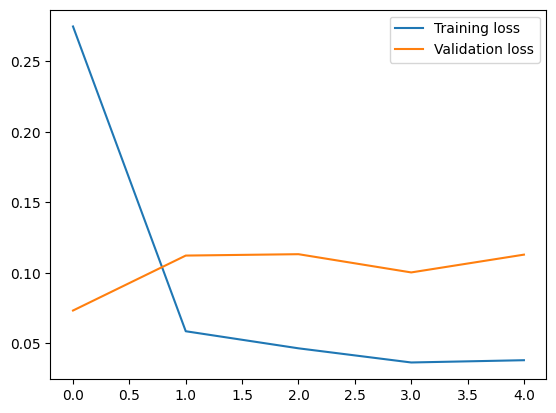

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [30]:
n_future = 90
forecast_period_date = pd.date_range(list(train_dates)[-1], periods=n_future,freq='1d').tolist()
print(len(forecast_period_date))
forecast = model.predict(trainX[-n_future:]) #forecast
print(forecast_period_date)
#print(forecast)

90
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[Timestamp('2018-11-30 00:00:00'), Timestamp('2018-12-01 00:00:00'), Timestamp('2018-12-02 00:00:00'), Timestamp('2018-12-03 00:00:00'), Timestamp('2018-12-04 00:00:00'), Timestamp('2018-12-05 00:00:00'), Timestamp('2018-12-06 00:00:00'), Timestamp('2018-12-07 00:00:00'), Timestamp('2018-12-08 00:00:00'), Timestamp('2018-12-09 00:00:00'), Timestamp('2018-12-10 00:00:00'), Timestamp('2018-12-11 00:00:00'), Timestamp('2018-12-12 00:00:00'), Timestamp('2018-12-13 00:00:00'), Timestamp('2018-12-14 00:00:00'), Timestamp('2018-12-15 00:00:00'), Timestamp('2018-12-16 00:00:00'), Timestamp('2018-12-17 00:00:00'), Timestamp('2018-12-18 00:00:00'), Timestamp('2018-12-19 00:00:00'), Timestamp('2018-12-20 00:00:00'), Timestamp('2018-12-21 00:00:00'), Timestamp('2018-12-22 00:00:00'), Timestamp('2018-12-23 00:00:00'), Timestamp('2018-12-24 00:00:00'), Timestamp('2018-12-25 00:00:00'), Timestamp('2018-12-26 00:00:00'), Timestamp('2018-12-27 00:00:00'), Timest

In [32]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
print(y_pred_future)

[194.17575 194.77989 195.02214 194.92323 194.74155 195.6706  197.31229
 199.33157 201.46404 203.38539 204.94594 206.50182 207.75363 208.94681
 210.05179 211.00471 212.22769 213.7455  215.1153  216.03764 216.5963
 217.09897 217.6375  218.28163 219.10907 220.06866 221.16763 222.4194
 223.56616 224.37857 224.5928  224.4545  224.03311 223.96259 223.90654
 224.29573 224.45656 224.04626 223.62794 223.23892 223.0713  222.74446
 222.5934  222.68056 222.68758 223.23322 223.77464 224.45396 225.10684
 225.88165 226.19032 226.11368 225.78787 225.8034  224.94115 223.87213
 223.80786 223.31078 223.28972 223.27657 222.69038 222.53749 222.47632
 222.34825 221.93045 221.8827  221.44547 220.76218 220.05435 220.2089
 220.59596 219.45403 217.66544 216.10002 215.37415 214.83559 213.90265
 211.92268 209.57314 206.81659 204.35538 202.50983 200.31328 196.73586
 193.33908 189.85558 186.84633 184.10986 182.5357  181.69844]


In [37]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_date:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

<Axes: xlabel='Date', ylabel='Open'>

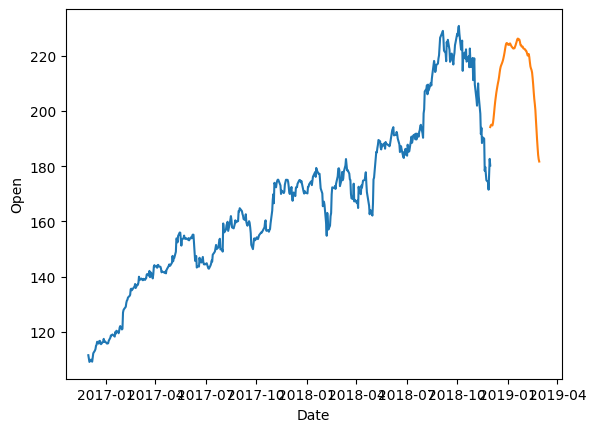

In [48]:

original = df[['Date', 'Open']].copy()
original['Date']=pd.to_datetime(original['Date'])
#original = original.loc[original['Date'] >= '2020-5-1']
#print(original.head())
sns.lineplot(x= original['Date'], y= original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])